# 1. Setup and Load Data

In [2]:
## Install Dependencies and Setup
!pip install --upgrade tensorflow numpy

In [17]:
## Import Libraries
import numpy as np
import seaborn as sns
import cv2 as cv
import imghdr
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

## import model and dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

In [4]:
## Remove dodgy Images
data_dir = 'Data'
image_exts =['jpeg','jpg','png','bmp']
print(os.listdir(data_dir))

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path= os.path.join(data_dir, image_class, image)
        try:
            img = cv.imread(image_path)
            tip= imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list: {}'. format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issues with image: {}'.format(image_path))
            ## os.remove(image_path)

['Happy', 'Sad']
Issues with image: Data\Happy\.ipynb_checkpoints
Issues with image: Data\Sad\.ipynb_checkpoints


In [5]:
img.shape

(1080, 1000, 3)

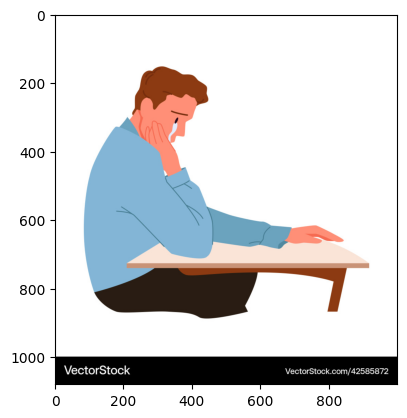

In [6]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

## Load Data


In [7]:
## building the data pipeline on the fly
data = tf.keras.utils.image_dataset_from_directory('Data')

## converting to accessable format
data_it = data.as_numpy_iterator()
batch = data_it.next()            ## accessing the data

Found 158 files belonging to 2 classes.


In [8]:
## values(labels) of images - happy and sad
batch[1]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0], dtype=int32)

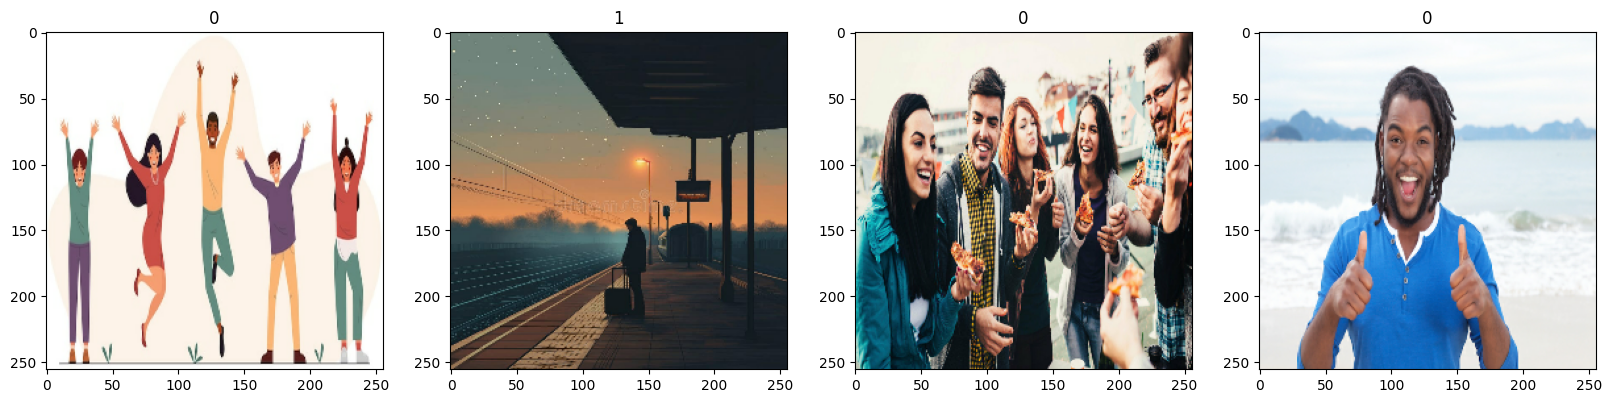

In [9]:
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for idx, img in enumerate(batch[0][1:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx+1])

0- happy, 1- sad

## Pre Process Data

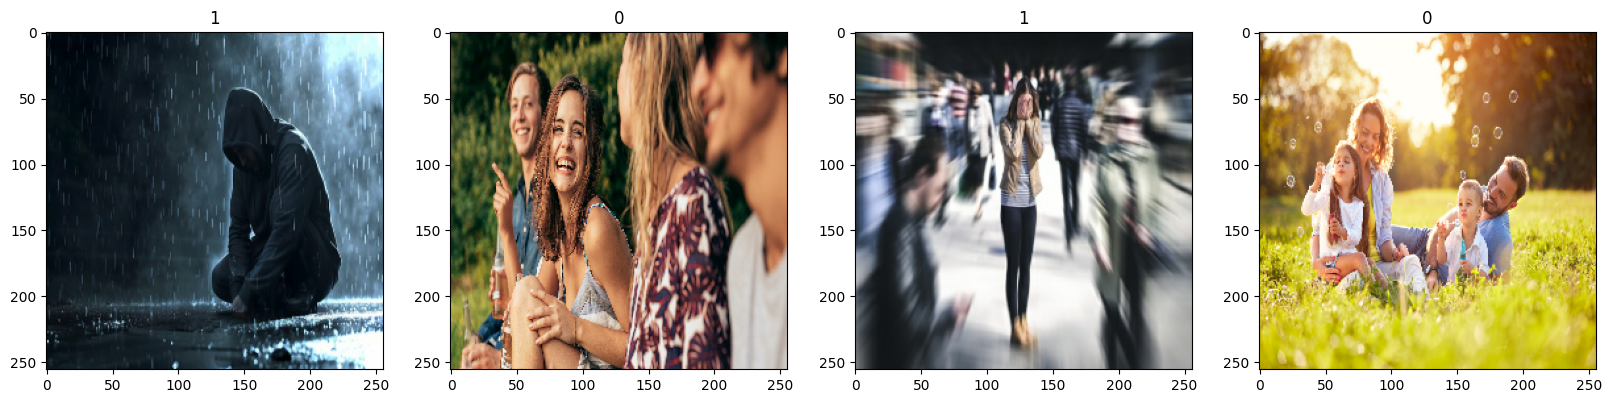

In [10]:
## Scaled Data
data = data.map(lambda x, y: (x/255, y))
scaled_it = data.as_numpy_iterator().next()
fig, ax = plt.subplots(ncols=4, figsize = (20, 20))
for idx, img in enumerate(scaled_it[0][:4]):
    ax[idx].imshow(img)      ## changed as value is now b/w 0-1
    ax[idx].title.set_text(scaled_it[1][idx])

In [11]:
## split data
print(len(data))

train_size =int(len(data)*.7)
val_size =int(len(data)*.2)
test_size =int(len(data)*.2)

print(train_size + val_size + test_size)

# take and skip method to define train, val, test data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

5
5


## Model Building


In [28]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

print(model.summary())

C:\Users\gunja\Downloads\python_ana\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

None


## Model Training

In [29]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

print(hist.history)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 963ms/step - accuracy: 0.6979 - loss: 1.6758 - val_accuracy: 0.4062 - val_loss: 1.1361
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 764ms/step - accuracy: 0.3724 - loss: 1.0863 - val_accuracy: 0.7188 - val_loss: 0.6055
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 0.6250 - loss: 0.6184 - val_accuracy: 0.5625 - val_loss: 0.6487
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step - accuracy: 0.6003 - loss: 0.6119 - val_accuracy: 0.6250 - val_loss: 0.5913
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 690ms/step - accuracy: 0.6081 - loss: 0.6084 - val_accuracy: 0.8438 - val_loss: 0.4799
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 748ms/step - accuracy: 0.7513 - loss: 0.5240 - val_accuracy: 0.8438 - val_loss: 0.4901
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.8490 - loss: 0.4150 - val_accuracy: 0.8438 - val_loss: 0.3784
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step - accuracy: 0.8815 - loss: 0.3549 - val_accuracy: 0.8438 - val_loss:

## Performance Plotting 

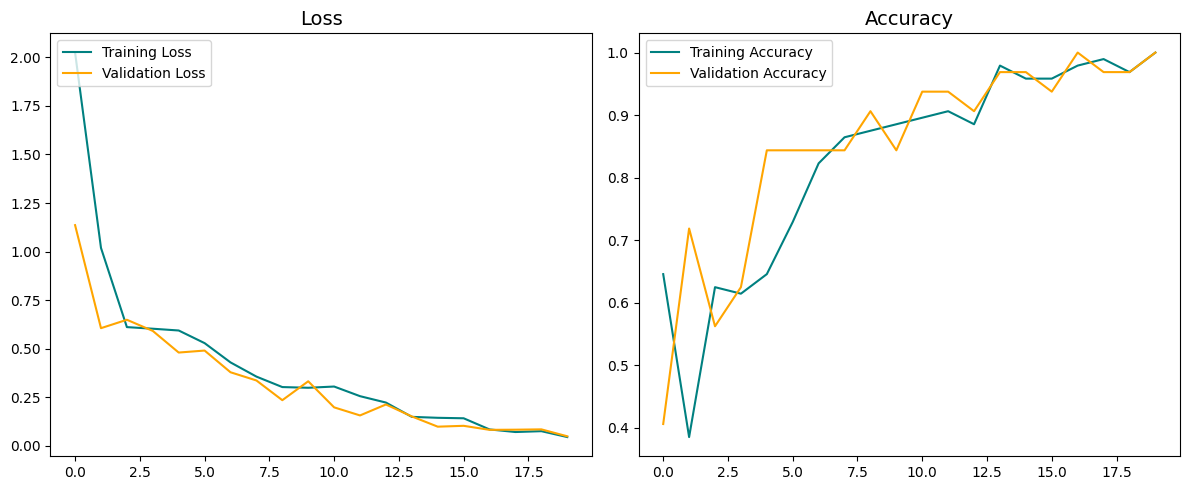

In [30]:
metrics = {'Loss': ('loss', 'val_loss'), 'Accuracy': ('accuracy', 'val_accuracy')}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (title, (train_metric, val_metric)) in enumerate(metrics.items()):
    axes[i].plot(hist.history[train_metric], color='teal', label=f'Training {title}')
    axes[i].plot(hist.history[val_metric], color='orange', label=f'Validation {title}')
    axes[i].set_title(title, fontsize=14)
    axes[i].legend(loc="upper left")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


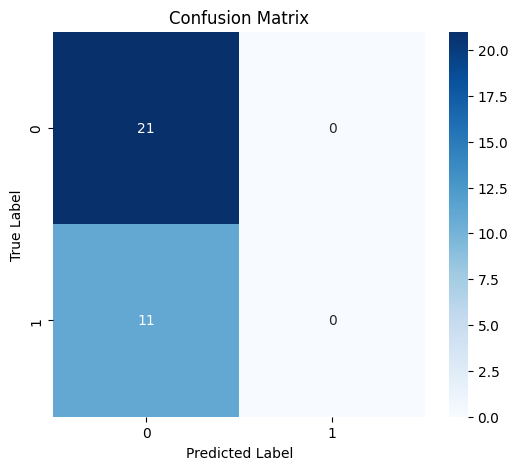

In [31]:
## Confusion Matrix
y_true = np.concatenate([y for x, y in val], axis=0) 
y_pred = np.argmax(model.predict(val), axis=1) 

cm = confusion_matrix(y_true, y_pred) 

plt.figure(figsize=(6, 5)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_true), 
            yticklabels=np.unique(y_true)) 

plt.xlabel("Predicted Label")  
plt.ylabel("True Label")
plt.title("Confusion Matrix")  
plt.show()

## Evaluate Performance

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    x,y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Precision:0.949999988079071, Recall:1.0, Accuracy:0.9666666388511658


## Testing

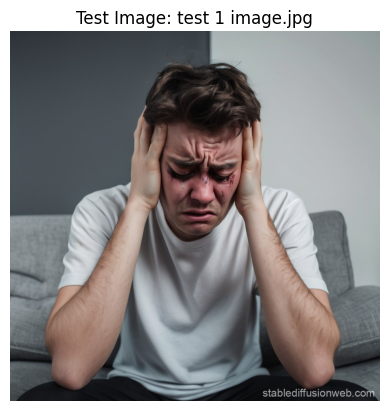

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted class for test 1 image.jpg: Sad



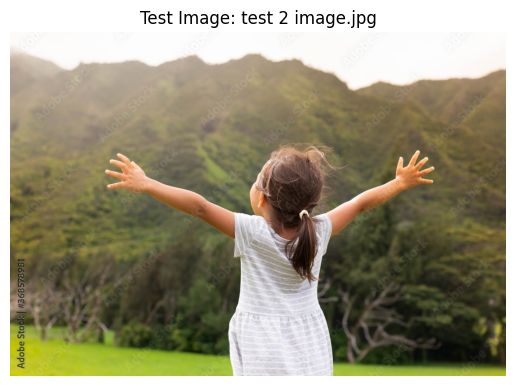

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class for test 2 image.jpg: Sad



In [33]:
image_files = ['test 1 image.jpg', 'test 2 image.jpg']
for image_file in image_files:
    img = cv.imread(image_file)
    img_resized = tf.image.resize(img, (256, 256))
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title(f"Test Image: {image_file}")
    plt.axis("off")
    plt.show()

    img_preprocessed = np.expand_dims(img_resized / 255.0, axis=0)

    yhat = model.predict(img_preprocessed)

    predicted_class = "Sad" if yhat > 0.5 else "Happy"
    print(f"Predicted class for {image_file}: {predicted_class}\n")

## Saving the model


In [34]:
model.save(os.path.join('models', 'happysadmodel.h5'))
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


In [35]:
yhatnew

array([[0.9854455]], dtype=float32)